In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from deep_macrofin import PDEModel
from deep_macrofin import ActivationType, OptimizerType, SamplingMethod, plot_loss_df, set_seeds

In [2]:
latex_var_map = {
    r"\gamma": "gamma",
    r"\rho": "rho",
    r"\mu^{y_1}": "mu_y1",
    r"\mu^{y_2}": "mu_y2",
    r"\sigma^{y_1}": "sig_y1",
    r"\sigma^{y_2}": "sig_y2",

    r"\mu^z": "muz",
    r"\sigma^z": "sigz",
    r"\mu_a^z": "muz_ari",
    r"\sigma_a^z": "sigz_ari",
    r"\mu_a^{z_2}": "muz2_ari",
    r"\sigma_a^{z_2}": "sigz2_ari",
    r"\mu^{z_2}": "muz2",
    r"\sigma^{z_2}": "sigz2",
    r"\mu^{q_1}": "mu_q1",
    r"\mu^{q_2}": "mu_q2",
    r"\sigma^{q_1}": "sig_q1",
    r"\sigma^{q_2}": "sig_q2",
    r"\zeta^1": "zeta1",
    r"\zeta^2": "zeta2",
    r"\mu^{k_1}": "mu_k1",
    r"\mu^{k_2}": "mu_k2",
    r"\sigma^{k_1}": "sig_k1",
    r"\sigma^{k_2}": "sig_k2",

    r"k_1": "k1",
    r"k_2": "k2",
    r"q_1": "q1",
    r"q_2": "q2",
}

params = {
    "gamma": 5,
    "rho": 0.05,
    "mu_y1": 0.05,
    "sig_y1": 0.2,
    "mu_y2": 0.05,
    "sig_y2": 0.05
}

base_model_dir ="./models/tree_2"

=============================Summary of Model tree2=============================
Config: {
 "batch_size": 100,
 "num_epochs": 1000,
 "lr": 0.0005,
 "loss_log_interval": 100,
 "optimizer_type": "Adam",
 "sampling_method": "UniformRandom",
 "loss_balancing": false,
 "bernoulli_prob": 0.9999,
 "loss_balancing_temp": 0.1,
 "loss_balancing_alpha": 0.999,
 "soft_adapt_interval": -1,
 "loss_soft_attention": false
}
Latex Variable Mapping:
{
 "\\gamma": "gamma",
 "\\rho": "rho",
 "\\mu^{y_1}": "mu_y1",
 "\\mu^{y_2}": "mu_y2",
 "\\sigma^{y_1}": "sig_y1",
 "\\sigma^{y_2}": "sig_y2",
 "\\mu^z": "muz",
 "\\sigma^z": "sigz",
 "\\mu_a^z": "muz_ari",
 "\\sigma_a^z": "sigz_ari",
 "\\mu_a^{z_2}": "muz2_ari",
 "\\sigma_a^{z_2}": "sigz2_ari",
 "\\mu^{z_2}": "muz2",
 "\\sigma^{z_2}": "sigz2",
 "\\mu^{q_1}": "mu_q1",
 "\\mu^{q_2}": "mu_q2",
 "\\sigma^{q_1}": "sig_q1",
 "\\sigma^{q_2}": "sig_q2",
 "\\zeta^1": "zeta1",
 "\\zeta^2": "zeta2",
 "\\mu^{k_1}": "mu_k1",
 "\\mu^{k_2}": "mu_k2",
 "\\sigma^{k_1}": "s

Total loss: 0.0000: 100%|██████████| 1000/1000 [00:49<00:00, 20.32it/s]


training finished, total time :: 49.22515821456909
Best model saved to ./models/tree_2/model_best.pt if valid
Model saved to ./models/tree_2/model.pt
Model loaded
===================================Evaluating===================================
loss :: hjbeq_1: 0.0000,
hjbeq_2: 0.0000,
hjbeq_3: 0.0000,
hjbeq_4: 0.0000,
total_loss: 0.0000


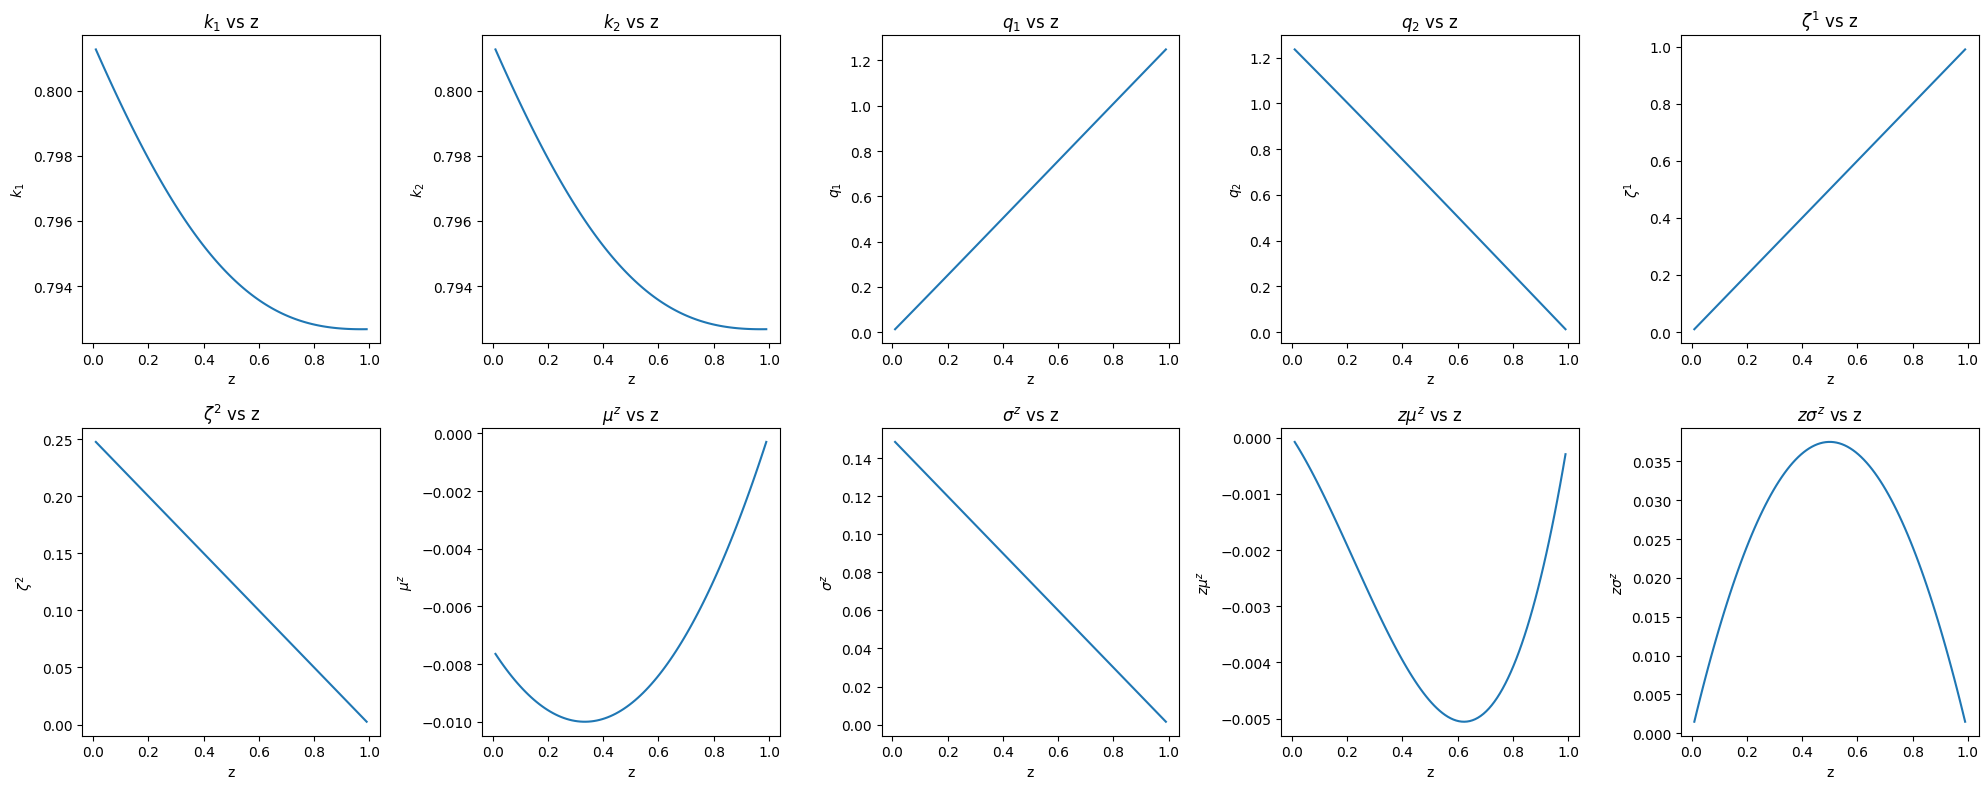

In [3]:
set_seeds(42)
model = PDEModel("tree2", 
                 config={"batch_size": 100, 
                         "num_epochs": 1000, 
                         "lr": 0.0005, 
                         "optimizer_type": OptimizerType.Adam}, 
                 latex_var_mapping=latex_var_map)
model.set_state(["z"], {"z": [0.01, 0.99]})
model.add_params(params)
model.add_endogs(["k1", "k2"], configs={
    "k1": {"positive": True, "hidden_units": [80] * 4},
    "k2": {"positive": True, "hidden_units": [80] * 4},
})
model.endog_vars["k2"].load_state_dict(model.endog_vars["k1"].state_dict())
model.add_equation(r"$q_1 &= \frac{z}{k_1}$")
model.add_equation(r"$q_2 &= \frac{1-z}{k_2}$")
model.add_equation("q1_z=deriv(q1, SV)[:,:1]")
model.add_equation("q1_zz=deriv(q1_z, SV)[:,:1]")
model.add_equation("q2_z=deriv(q2, SV)[:,:1]")
model.add_equation("q2_zz=deriv(q2_z, SV)[:,:1]")
model.add_equation(r"$\mu^z &= \mu^{y_1} - (z * \mu^{y_1} + (1-z) * \mu^{y_2}) + (z * \sigma^{y_1} + (1-z) * \sigma^{y_2}) * (z * \sigma^{y_1} + (1-z) * \sigma^{y_2} - \sigma^{y_1})$")
model.add_equation(r"$\sigma^z &= \sigma^{y_1} - (z * \sigma^{y_1} + (1-z) * \sigma^{y_2})$")
model.add_equation(r"$\mu_a^z &= \mu^z * z$")
model.add_equation(r"$\sigma_a^z &= \sigma^z * z$")
model.add_equation(r"$\mu_a^{z_2} &= -\mu_a^z$")
model.add_equation(r"$\sigma_a^{z_2} &= -\sigma_a^z$")
model.add_equation(r"$\mu^{z_2} &= \frac{\mu_a^{z_2}}{1-z}$")
model.add_equation(r"$\sigma^{z_2} &= \frac{\sigma_a^{z_2}}{1-z}$")
model.add_equation(r"$\mu^{q_1} &= \frac{1}{q_1} * \left(\frac{\partial q_1}{\partial z} * \mu_a^z + \frac{1}{2} * \frac{\partial^2 q_1}{\partial z^2} * (\sigma_a^z)^2\right)$")
model.add_equation(r"$\mu^{q_2} &= \frac{1}{q_2} * \left(\frac{\partial q_2}{\partial z} * \mu_a^z + \frac{1}{2} * \frac{\partial^2 q_2}{\partial z^2} * (\sigma_a^z)^2\right)$")
model.add_equation(r"$\sigma^{q_1} &= \frac{1}{q_1} * \frac{\partial q_1}{\partial z} * \sigma_a^z$")
model.add_equation(r"$\sigma^{q_2} &= \frac{1}{q_2} * \frac{\partial q_2}{\partial z} * \sigma_a^z$")
model.add_equation(r"$r &= \rho + \gamma * (z * \sigma^{y_1} + (1-z) * \sigma^{y_2}) - \frac{1}{2} * \gamma * (\gamma + 1) * ((z*\sigma^{y_1})^2 + ((1-z)*\sigma^{y_2})^2)$")
model.add_equation(r"$\zeta^1 &= \gamma * z * \sigma^{y_1}$")
model.add_equation(r"$\zeta^2 &= \gamma * (1-z) * \sigma^{y_2}$")
model.add_equation(r"$\mu^{k_1} &= \mu^z - \mu^{q_1} + \sigma^{q_1} * (\sigma^{q_1} - \sigma^z)$")
model.add_equation(r"$\mu^{k_2} &= \mu^{z_2} - \mu^{q_2} + \sigma^{q_2} * (\sigma^{q_2} - \sigma^{z_2})$")
model.add_equation(r"$\sigma^{k_1} &= \sigma^z - \sigma^{q_1}$")
model.add_equation(r"$\sigma^{k_2} &= \sigma^{z_2} - \sigma^{q_2}$")

model.add_hjb_equation(r"$\frac{\partial k_1}{\partial z} * \mu_a^z + \frac{1}{2} * \frac{\partial^2 k_1}{\partial z^2} * (\sigma_a^z)^2 - \mu^{k_1} * k_1$")
model.add_hjb_equation(r"$\frac{\partial k_2}{\partial z} * \mu_a^z + \frac{1}{2} * \frac{\partial^2 k_2}{\partial z^2} * (\sigma_a^z)^2 - \mu^{k_2} * k_2$")
model.add_hjb_equation(r"$\frac{\partial k_1}{\partial z} * \sigma_a^z - \sigma^{k_1} * k_1$")
model.add_hjb_equation(r"$\frac{\partial k_2}{\partial z} * \sigma_a^z - \sigma^{k_2} * k_2$")

print(model)
if not os.path.exists(f"{base_model_dir}/model.pt"):
    model.train_model(base_model_dir, "model.pt", True)
    model.load_model(torch.load(f"{base_model_dir}/model_best.pt"))
    model.eval_model(True)
else:
    model.load_model(torch.load(f"{base_model_dir}/model_best.pt"))
    model.eval_model(True)

model.plot_vars([r"$k_1$", r"$k_2$", r"$q_1$", r"$q_2$", r"$\zeta^1$", r"$\zeta^2$",
                 r"$\mu^z$", r"$\sigma^z$", r"$z\mu^z=\mu_a^z$", r"$z\sigma^z=\sigma_a^z$"], ncols=5)